In this notebook, we load the preprocessed dataset as created in 'Project_preprocessing' and build a Polynomial Regression model. The preprocessed dataset is split into train and test sets. <br>
1. Naive Baseline - Predictions on the test set are performed using 'Naive Baseline' model (mean strategy). The baseline Root mean square error (RMSE) is thus established.
2. Default model - The default Polynomial Regression model is evaluated with 5 fold cross validation on train set. The model is then fit on the train data and predictions are performed on test data. RMSE using default model on test data is reported.
3. Tuned model - Lastly, we optimize the parameters of the model using 5 cross validation. An extensive parameter search is performed using several grid searches. 'neg_root_mean_squared_error' is used as scoring function during grid search. The 'best estimator' model obtained after grid searches with 5 fold cross validation is finally used to perform predictions on the test set. RMSE obtained using tuned model on test set is compared with that of Default model and Naive Baseline model.    

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
#read preprocessed dataset 
dataset = pd.read_csv('melbourne-airbnb.csv')
X = dataset.drop('price',axis=1)
y = dataset['price']

In [44]:
#split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Naive Baseline

In [52]:
#create naive baseline
from sklearn.metrics import mean_squared_error, r2_score
mean_price = np.mean(y)
y_test_naive = np.repeat(mean_price, len(y_test))
naive_rmse = mean_squared_error(y_test, y_test_naive)
naive_rmse = np.sqrt(naive_rmse)
naive_r2 = r2_score(y_test,y_test_naive)
print('Naive Baseline RMSE on test set: ' + str(round(naive_rmse,2)))
print('Naive Baseline R2 on test set: ' + str(round(naive_r2,2)))


Naive Baseline RMSE on test set: 75.75
Naive Baseline R2 on test set: -0.0


## Polynomial Regression - Default Parameters
Fit default model on train set, evaluate on test set and calculate RMSE.

In [46]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

steps = [('poly',PolynomialFeatures()), ('linear',LinearRegression())]
pipeline = Pipeline(steps)

# evaluate default model with 5 fold cross validation on train set
scores = cross_val_score(pipeline,X_train,y_train, cv=5, scoring='neg_root_mean_squared_error')
mean_score = abs(np.mean(scores))

#fit model on entire train set and predict on test set
pipeline.fit(X_train,y_train)
y_pred_def = pipeline.predict(X_test)

# evaluate predictions made on test set
def_rmse = mean_squared_error(y_test, y_pred_def)
def_rmse = np.sqrt(def_rmse)
def_r2 = r2_score(y_test,y_pred_def)

print('Polynomial Regression (default parameters) mean cross validated RMSE on train set: ' + str(round(mean_score,2)))
print()
print("Polynomial Regression (default parameters) R2 score on test set: " + str(round(def_r2,1)))
print()
print("Polynomial Regression (default parameters) RMSE on test set: " + str(round(def_rmse,2)))


Polynomial Regression (default parameters) mean cross validated RMSE on train set: 54.76

Polynomial Regression (default parameters) R2 score on test set: 0.5

Polynomial Regression (default parameters) RMSE on test set: 52.91


## Polynomial Regression - Hyperparameter Optimization
Perform hyperparameter tuning using grid search with 5 fold cross validation on train set. Evaluate tuned model on test set and calculate RMSE.  

In [47]:
from sklearn.model_selection import GridSearchCV

steps = [('poly',PolynomialFeatures()), ('linear',LinearRegression())]
pipeline = Pipeline(steps)

parameters = {'poly__degree':[2,3],'linear__normalize': [True, False]}
grid_poly = GridSearchCV(pipeline,param_grid=parameters,cv=5, scoring='neg_root_mean_squared_error')
grid_poly.fit(X_train,y_train)              
print('Best Parameters with grid search:') 
print(grid_poly.best_params_)  

poly_rmse = abs(grid_poly.best_score_)
best_std = grid_poly.cv_results_['std_test_score'][grid_poly.best_index_]
print('Mean cross validated RMSE with best estimator: '+ str(round(poly_rmse,2)) + ', Standard deviation: ' + str(round(best_std,2)))

Best Parameters with grid search:
{'linear__normalize': False, 'poly__degree': 2}
Mean cross validated RMSE with best estimator: 54.76, Standard deviation: 0.59


Note: Higher orders of polynomial features beyond 3 were not evaluated as it scales exponentially took exceptionally long to compute.

In [48]:
#predict using model with tuned hyperparameters
y_pred_tuned = grid_poly.predict(X_test)
poly_tuned_r2 = r2_score(y_test,y_pred_tuned)
poly_tuned_rmse = mean_squared_error(y_test, y_pred_tuned)
poly_tuned_rmse = np.sqrt(poly_tuned_rmse)
print('R2 score using tuned Polynomial Regression: ' + str(round(poly_tuned_r2,1)))
print()
print('RMSE using tuned Polynomial Regression on test set: ' + str(round(poly_tuned_rmse,2)))

R2 score using tuned Polynomial Regression: 0.5

RMSE using tuned Polynomial Regression on test set: 52.91


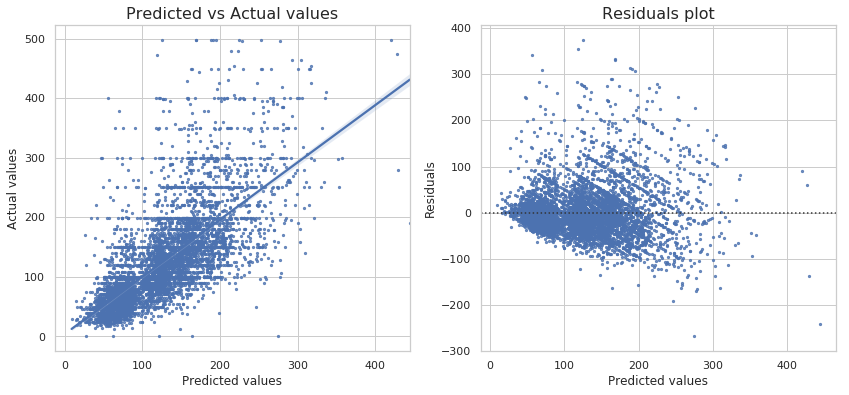

In [49]:
#plot predicted vs actual values and residuals plot

residuals = y_test-y_pred_tuned

sns.set(style="whitegrid")
fig,(ax1,ax2) = plt.subplots(1,2, figsize= (14,6))
sns.regplot(x = y_pred_tuned, y=y_test,scatter_kws={'s':5}, ax=ax1)
ax1.set_xlabel('Predicted values',fontsize=12)
ax1.set_ylabel('Actual values',fontsize=12)
ax1.set_title('Predicted vs Actual values', fontsize = 16)
sns.residplot(x=y_pred_tuned, y=residuals,scatter_kws={'s':5}, ax=ax2)
ax2.set_xlabel('Predicted values',fontsize=12)
ax2.set_ylabel('Residuals',fontsize=12)
ax2.set_title('Residuals plot', fontsize=16);

The predicted values using tuned model follow the overall trend of actual values. Predictions are more accurate in the range of ~ $50-250. Beyond this range, the model performance is poor and mostly under or overestimating the price. 

In [50]:
#final summary
print('Summarizing: ')
print()
print('Naive Baseline RMSE on test set: ' + str(round(naive_rmse,2)))
print()
print("Polynomial Regression (default parameters) RMSE on test set: " + str(round(def_rmse,2)))
print()
print('Polynomial Regression (tuned parameters) RMSE on test set: ' + str(round(poly_tuned_rmse,2)))


Summarizing: 

Naive Baseline RMSE on test set: 75.75

Polynomial Regression (default parameters) RMSE on test set: 52.91

Polynomial Regression (tuned parameters) RMSE on test set: 52.91


A significantly lower RMSE using Polynomial Regression model was obtained than Naive Baseline model. Default parameters of Polynomial regression model were found to be the best parameters after grid search, therefore no further improvement in RMSE score was observed with model optimization.